In [279]:
#Bibliotecas

import pandas as pd
import numpy as np
import shutil
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [286]:
#Arquivos e variaveis

input_file = "c:\\Users\\thgcn\\OneDrive\\Academico\\Financial-Reports-Impact\\data\\final_data.csv"

final_data = pd.read_csv(input_file)

In [287]:
final_data.describe()

,CD_CVM,Close,Return,event,return_week,return_month,Year
count,3225.0,3225.000000,3224.000000,3225.000000,615.000000,112.000000,3225.000000
mean,19348.0,22.555047,0.000097,0.014884,0.000946,-0.001159,2016.007442
std,0.0,6.869489,0.020068,0.121106,0.038401,0.080957,3.740987
min,19348.0,11.633995,-0.198015,0.000000,-0.153768,-0.291205,2010.000000
25%,19348.0,16.515150,-0.011279,0.000000,-0.023243,-0.055503,2013.000000
50%,19348.0,21.200001,0.000000,0.000000,0.001031,0.000773,2016.000000
75%,19348.0,27.673332,0.010992,0.000000,0.023772,0.050451,2019.000000
max,19348.0,39.689999,0.111276,1.000000,0.190721,0.253973,2022.000000


In [254]:
# NÃO EXECUTAR Gera os dataframes de retorno mensal e semanal com INDEX
def separate_returns(final_data):
    # Inicializar colunas se não existirem
    if 'return_week' not in final_data.columns:
        final_data['return_week'] = np.nan
    if 'return_month' not in final_data.columns:
        final_data['return_month'] = np.nan

    first_return_week_list = []
    remaining_return_week_list = []
    first_return_month_list = []
    remaining_return_month_list = []

    start_idx = 0

    while start_idx < len(final_data):
        # Encontra o próximo evento
        if 1 in final_data[start_idx:]['event'].values:
            event_idx = final_data[start_idx:]['event'].eq(1).idxmax()
        else:
            break

        # Calcular o primeiro retorno semanal logo após o evento
        if event_idx + 4 < len(final_data):
            final_data.loc[event_idx + 4, 'return_week'] = np.log(final_data.loc[event_idx + 4, 'Close'] / final_data.loc[event_idx, 'Close'])
            first_return_week_list.append(final_data.iloc[event_idx + 4])

        # Calcular os retornos semanais restantes até o próximo evento
        for i in range(event_idx + 5, len(final_data), 7):
            if i + 6 < len(final_data) and final_data.loc[i, 'event'] != 1:
                final_data.loc[i + 6, 'return_week'] = np.log(final_data.loc[i + 6, 'Close'] / final_data.loc[i, 'Close'])
                remaining_return_week_list.append(final_data.iloc[i + 6])
            elif i + 6 >= len(final_data):
                break

        # Calcular o primeiro retorno mensal logo após o evento
        if event_idx + 21 < len(final_data):
            final_data.loc[event_idx + 21, 'return_month'] = np.log(final_data.loc[event_idx + 21, 'Close'] / final_data.loc[event_idx, 'Close'])
            first_return_month_list.append(final_data.iloc[event_idx + 21])

        # Calcular os retornos mensais restantes até o próximo evento
        for i in range(event_idx + 22, len(final_data), 22):
            if i + 21 < len(final_data) and final_data.loc[i, 'event'] != 1:
                final_data.loc[i + 21, 'return_month'] = np.log(final_data.loc[i + 21, 'Close'] / final_data.loc[i, 'Close'])
                remaining_return_month_list.append(final_data.iloc[i + 21])
            elif i + 21 >= len(final_data):
                break

        # Reinicia após o evento
        start_idx = event_idx + 1

    # Criar DataFrames para o primeiro e os demais retornos semanais e mensais
    first_return_week_df = pd.DataFrame(first_return_week_list).reset_index()
    remaining_return_week_df = pd.DataFrame(remaining_return_week_list).reset_index()
    first_return_month_df = pd.DataFrame(first_return_month_list).reset_index()
    remaining_return_month_df = pd.DataFrame(remaining_return_month_list).reset_index()
    
    return first_return_week_df, remaining_return_week_df, first_return_month_df, remaining_return_month_df

# Exemplo de uso com um DataFrame
# final_data = pd.read_csv('path_to_your_file.csv')  # Carregar os dados

# Aplicar a função ao DataFrame
first_return_week_df, remaining_return_week_df, first_return_month_df, remaining_return_month_df = separate_returns(final_data)


In [288]:
# Dataframe "first_return_week_list"
first_return_week_list = final_data.loc[final_data['event'].shift(-1) == 1, 'return_week'].dropna().tolist()

# Dataframe "remaining_return_week_list"
remaining_return_week_list = final_data.loc[(final_data['event'].shift(-1) != 1) & (final_data['event'] == 0), 'return_week'].dropna().tolist()

# Dataframe "first_return_month_list"
first_return_month_list = final_data.loc[final_data['event'].shift(-1) == 1, 'return_month'].dropna().tolist()

# Dataframe "remaining_return_month_list"
remaining_return_month_list = final_data.loc[(final_data['event'].shift(-1) != 1) & (final_data['event'] == 0), 'return_month'].dropna().tolist()

# Exibindo os resultados
print("first_return_week_list =", first_return_week_list)
print("remaining_return_week_list =", remaining_return_week_list)
print("first_return_month_list =", first_return_month_list)
print("remaining_return_month_list =", remaining_return_month_list)


first_return_week_list = [-0.04336865046316223, 0.02641346444201724, 0.009164210932151272, 0.027006272669982904, -0.005622637010293775, -0.01676013223514444, 0.03377242273272888, 0.029462032730316067]
remaining_return_week_list = [-0.027800654468906668, -0.03713391955716129, -0.036564661602797095, 0.012850552096502458, -0.07225358556989954, 0.04398377239164312, -0.06495965800603258, 0.04261809959652257, 0.021334092963257004, -0.013245218273652059, -0.01899646575410785, 0.054266549589037635, 0.019702471824855447, -0.01279985251578739, -0.01048514386046736, 0.006386505671630492, -0.04490886482179903, -0.04726580650359685, -0.0691918250718134, 0.026084538737456663, -0.04388865207870797, 0.01584541221665954, 0.0073613020143397144, -0.022633926414816142, 0.011717157229074434, 0.08577076745483482, 0.0034998313302599545, 0.03731087212338837, -0.023107627564864, 0.012605249266758408, 0.017722967711897575, -0.03830645917860255, 0.03278984798600169, -0.02270422857433227, 0.05252671135471466, -0.

In [293]:
pd.DataFrame(first_return_week_list, columns=['return_week']).describe()

,return_week
count,8.000000
mean,0.007508
std,0.027417
min,-0.043369
25%,-0.008407
50%,0.017789
75%,0.027620
max,0.033772


In [261]:
# Analise se tem linhas duplicadas

def find_duplicates(df):
    # Identifica todas as linhas duplicadas (incluindo a primeira ocorrência)
    duplicates = df[df.duplicated(keep=False)]
    
    # Conta o número de linhas duplicadas (excluindo a primeira ocorrência)
    num_duplicates = len(df[df.duplicated()])
    
    # Agrupa as duplicatas e lista seus índices
    duplicate_indices = duplicates.groupby(list(df.columns)).apply(lambda x: list(x.index))

    return num_duplicates, duplicate_indices

num_duplicates, duplicate_indices = find_duplicates(remaining_return_week_df)
print(f"Number of duplicate lines: {num_duplicates}")
print("Duplicate indices:")
print(duplicate_indices)


Number of duplicate lines: 0
Duplicate indices:
Empty DataFrame
Columns: []
Index: []


In [262]:
remaining_return_week_df.to_csv("first_return_week_df.csv")

In [246]:
# Carrega os datasets
# Retornos diarios
nxt_return = filtered_data['nxt_return'].dropna()
Returns = final_data['Return'].dropna()
#Retornos semanais
first_return_week = first_return_week_df["return_week"]
remaining_return_week = remaining_return_week_df["return_week"]
#Retornos mensais
first_return_month = first_return_month_df["return_month"]
remaining_return_month = remaining_return_month_df["return_month"]


In [260]:
import pandas as pd

# Supondo que os dados estejam em um DataFrame chamado df com as colunas correspondentes
data = {
    'Returns': Returns,
    'nxt_return': nxt_return,
    'remaining_return_week': remaining_return_week,
    'first_return_week': first_return_week,
    'remaining_return_month': remaining_return_month,
    'first_return_month': first_return_month
}

# Criação do DataFrame
df = pd.DataFrame(data)

# Descrição estatística dos dados
description = df.describe()

# Exibindo a descrição estatística
print(description)


           Returns  nxt_return  remaining_return_week  first_return_week  \
count  3224.000000   48.000000            2673.000000          48.000000   
mean      0.000097   -0.000234               0.001115           0.003808   
std       0.020068    0.025381               0.046883           0.045021   
min      -0.198015   -0.060625              -0.291910          -0.146461   
25%      -0.011279   -0.014663              -0.026072          -0.014727   
50%       0.000000   -0.001989               0.001907           0.001033   
75%       0.010992    0.022919               0.030688           0.029427   
max       0.111276    0.040834               0.238411           0.144273   

       remaining_return_month  first_return_month  
count             1711.000000           48.000000  
mean                 0.002572           -0.000316  
std                  0.090575            0.108993  
min                 -0.508484           -0.373315  
25%                 -0.054292           -0.051100  
50%

In [248]:
remaining_return_week  

0      -0.014469
1       0.036159
2       0.056040
3      -0.038582
4       0.019180
          ...   
3411   -0.021478
3412   -0.097874
3413   -0.001154
3414   -0.088497
3415    0.065104
Name: return_week, Length: 2673, dtype: float64

In [ ]:
#NÃO EXECUTAR
# Garantir que a coluna 'event' seja do tipo string
final_data['event'] = final_data['event'].astype(str)

# Filtra as linhas onde o valor da coluna 'event' é igual a '1'
filtered_data = final_data[final_data['event'].str.strip() == '1']

# Adiciona uma coluna chamada 'next_value' que contém o valor da próxima linha de 'data'
filtered_data['nxt_return'] = final_data['Return'].shift(-1)

# Limpar as linhas que contem null:
#final_data = final_data.dropna()
#filtered_data = filtered_data.dropna()
#first_return = filtered_data['nxt_return'].dropna()
#returns = final_data['Return'].dropna()

In [ ]:
first_return_month.describe()


Comparação de Retornos Diários:


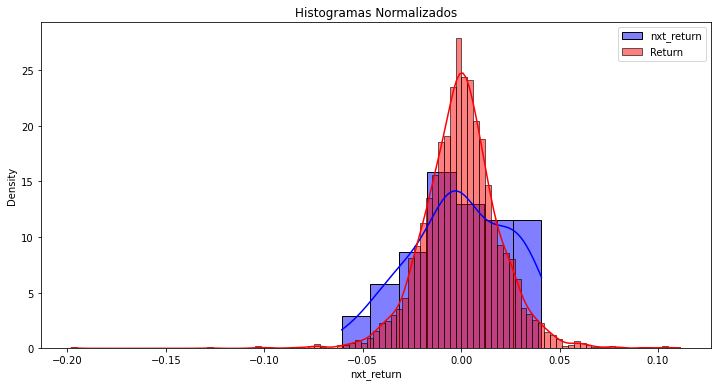

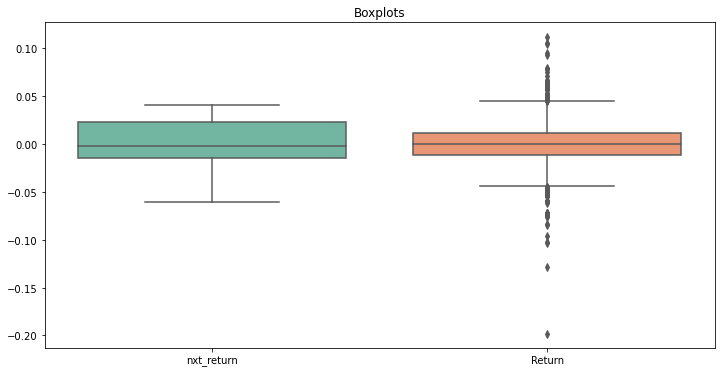

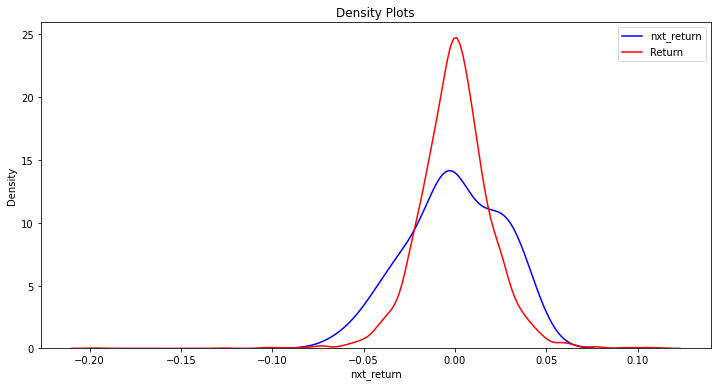

Estatísticas Descritivas:
nxt_return
count    48.000000
mean     -0.000234
std       0.025381
min      -0.060625
25%      -0.014663
50%      -0.001989
75%       0.022919
max       0.040834
Name: nxt_return, dtype: float64

Return
count    3224.000000
mean        0.000097
std         0.020068
min        -0.198015
25%        -0.011279
50%         0.000000
75%         0.010992
max         0.111276
Name: Return, dtype: float64

Mann-Whitney U Test: U-stat=77646.0, p-value=0.9669116494199598

Kolmogorov-Smirnov Test: KS-stat=0.17318031430934658, p-value=0.1036904996425645

Levene Test: stat=7.586491903037072, p-value=0.005913261739923997

Bootstrap mean 95% CI for nxt_return: [-0.00722221  0.0070404 ]
Bootstrap median 95% CI for nxt_return: [-0.00493129  0.00919087]
Bootstrap mean 95% CI for Return: [-0.00056582  0.00070733]
Bootstrap median 95% CI for Return: [-0.00034874  0.00048839]

Importâncias das Características: [1.]
ROC AUC Score: 0.9925526002894954

Comparação de Retornos Semanais

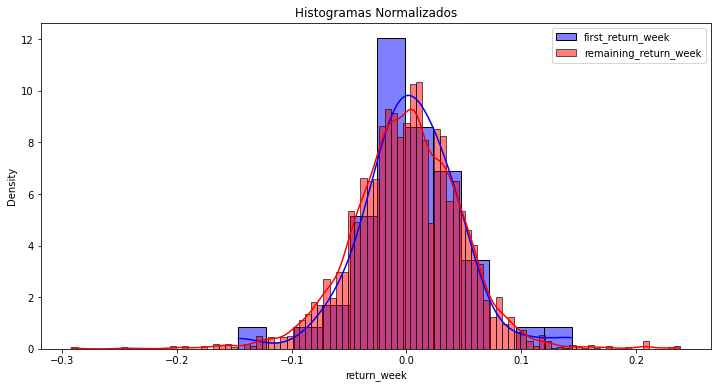

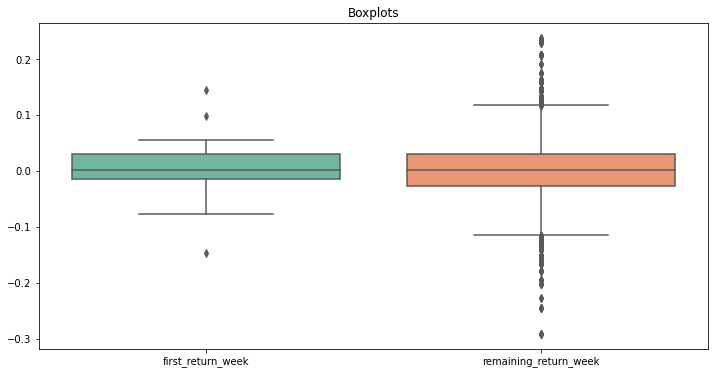

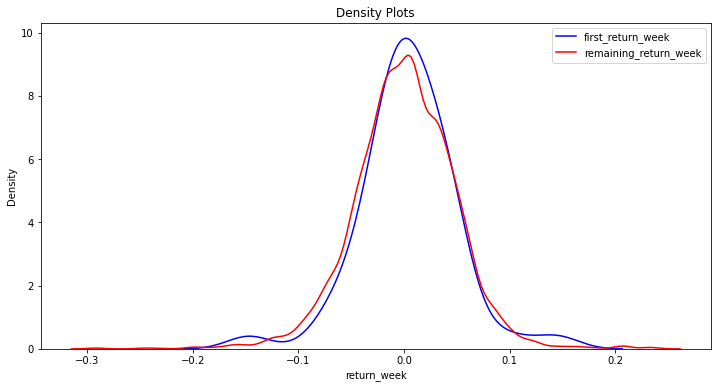

Estatísticas Descritivas:
first_return_week
count    48.000000
mean      0.003808
std       0.045021
min      -0.146461
25%      -0.014727
50%       0.001033
75%       0.029427
max       0.144273
Name: return_week, dtype: float64

remaining_return_week
count    10071.000000
mean         0.000470
std          0.048287
min         -0.291910
25%         -0.027455
50%          0.001691
75%          0.030884
max          0.238411
Name: return_week, dtype: float64

Mann-Whitney U Test: U-stat=252385.0, p-value=0.5968228210374809

Kolmogorov-Smirnov Test: KS-stat=0.11828517525568466, p-value=0.47686232656333405

Levene Test: stat=1.0012196263626851, p-value=0.3170395050688692

Bootstrap mean 95% CI for first_return_week: [-0.00881423  0.01662123]
Bootstrap median 95% CI for first_return_week: [-0.00707978  0.01387794]
Bootstrap mean 95% CI for remaining_return_week: [-0.00039635  0.00145349]
Bootstrap median 95% CI for remaining_return_week: [0.00059397 0.00247481]

Importâncias das Caracterí

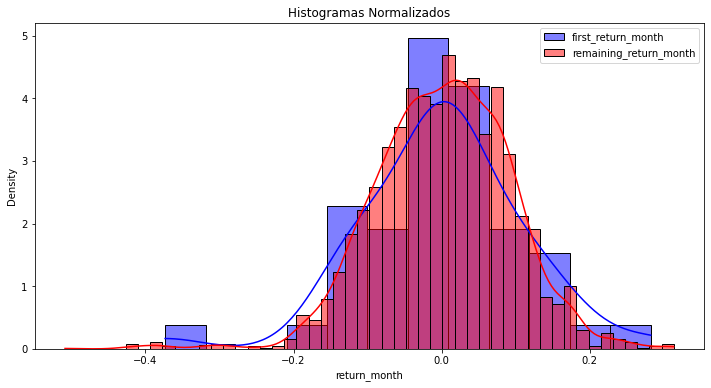

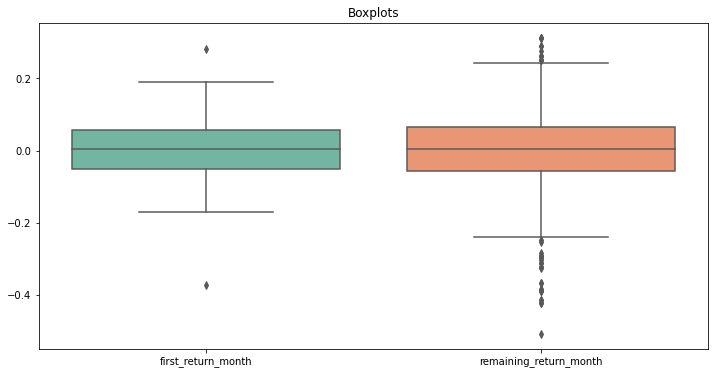

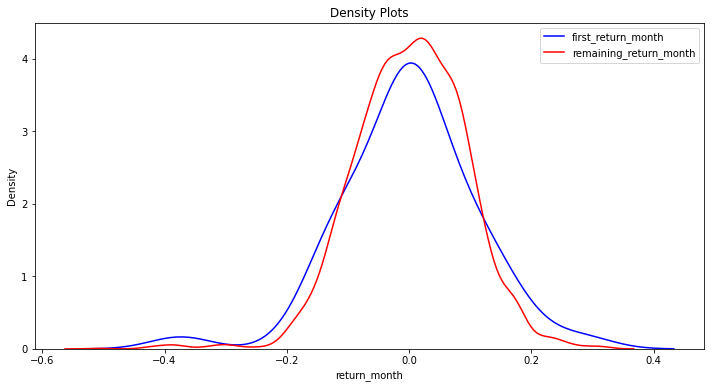

Estatísticas Descritivas:
first_return_month
count    48.000000
mean     -0.000316
std       0.108993
min      -0.373315
25%      -0.051100
50%       0.003636
75%       0.056905
max       0.282274
Name: return_month, dtype: float64

remaining_return_month
count    3155.000000
mean        0.002215
std         0.090796
min        -0.508484
25%        -0.056938
50%         0.005220
75%         0.065260
max         0.313309
Name: return_month, dtype: float64

Mann-Whitney U Test: U-stat=74448.0, p-value=0.8415127875870824

Kolmogorov-Smirnov Test: KS-stat=0.0966785525620708, p-value=0.7318509690581985

Levene Test: stat=0.6997283795063147, p-value=0.40293741801704386

Bootstrap mean 95% CI for first_return_month: [-0.02973348  0.03102443]
Bootstrap median 95% CI for first_return_month: [-0.02607428  0.0244101 ]
Bootstrap mean 95% CI for remaining_return_month: [-0.00086704  0.00522586]
Bootstrap median 95% CI for remaining_return_month: [0.001616   0.00883658]

Importâncias das Característ

In [97]:
# Criação dos histogramas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Função para exibir visualizações e testes estatísticos
def analyze_returns(return_1, return_2, label_1, label_2):
    # 1. Visualização
    # Histogramas normalizados
    plt.figure(figsize=(12, 6))
    sns.histplot(return_1, kde=True, stat='density', label=label_1, color='blue')
    sns.histplot(return_2, kde=True, stat='density', label=label_2, color='red')
    plt.legend()
    plt.title('Histogramas Normalizados')
    plt.show()

    # Boxplots
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=[return_1, return_2], palette='Set2')
    plt.xticks([0, 1], [label_1, label_2])
    plt.title('Boxplots')
    plt.show()

    # Density Plot (KDE)
    plt.figure(figsize=(12, 6))
    sns.kdeplot(return_1, label=label_1, color='blue')
    sns.kdeplot(return_2, label=label_2, color='red')
    plt.legend()
    plt.title('Density Plots')
    plt.show()

    # 2. Estatísticas Descritivas
    print("Estatísticas Descritivas:")
    print(label_1)
    print(return_1.describe())
    print(f"\n{label_2}")
    print(return_2.describe())

    # 3. Testes de Hipóteses
    # Teste U de Mann-Whitney
    u_stat, p_value = stats.mannwhitneyu(return_1, return_2)
    print(f"\nMann-Whitney U Test: U-stat={u_stat}, p-value={p_value}")

    # Teste de Kolmogorov-Smirnov
    ks_stat, p_value = stats.ks_2samp(return_1, return_2)
    print(f"\nKolmogorov-Smirnov Test: KS-stat={ks_stat}, p-value={p_value}")

    # Teste de Levene para variâncias
    levene_stat, p_value = stats.levene(return_1, return_2)
    print(f"\nLevene Test: stat={levene_stat}, p-value={p_value}")

    # 4. Reamostragem
    # Bootstrapping para média e mediana
    bootstrap_means_1 = []
    bootstrap_medians_1 = []
    bootstrap_means_2 = []
    bootstrap_medians_2 = []

    for _ in range(1000):
        sample_1 = resample(return_1, replace=True)
        sample_2 = resample(return_2, replace=True)
        bootstrap_means_1.append(np.mean(sample_1))
        bootstrap_medians_1.append(np.median(sample_1))
        bootstrap_means_2.append(np.mean(sample_2))
        bootstrap_medians_2.append(np.median(sample_2))

    print(f"\nBootstrap mean 95% CI for {label_1}: {np.percentile(bootstrap_means_1, [2.5, 97.5])}")
    print(f"Bootstrap median 95% CI for {label_1}: {np.percentile(bootstrap_medians_1, [2.5, 97.5])}")
    print(f"Bootstrap mean 95% CI for {label_2}: {np.percentile(bootstrap_means_2, [2.5, 97.5])}")
    print(f"Bootstrap median 95% CI for {label_2}: {np.percentile(bootstrap_medians_2, [2.5, 97.5])}")

    # Balanceamento de amostras
    balanced_1 = resample(return_1, n_samples=len(return_2), random_state=42)

    # 5. Machine Learning
    # Preparar os dados para o modelo
    X = np.concatenate([return_1.values.reshape(-1, 1), return_2.values.reshape(-1, 1)])
    y = np.concatenate([np.zeros(len(return_1)), np.ones(len(return_2))])

    # Treinar o modelo de Random Forest
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X, y)

    # Avaliar a importância das características
    feature_importances = rf.feature_importances_
    print(f"\nImportâncias das Características: {feature_importances}")

    # Avaliar o modelo
    roc_auc = roc_auc_score(y, rf.predict_proba(X)[:, 1])
    print(f"ROC AUC Score: {roc_auc}")

# Função principal
def main():
    # Retornos diários
    daily_return_1 = filtered_data['nxt_return'].dropna()
    daily_return_2 = final_data['Return'].dropna()

    # Retornos semanais
    first_return_week = first_return_week_df['return_week'].dropna()
    remaining_return_week = remaining_return_week_df['return_week'].dropna()

    # Retornos mensais
    first_return_month = first_return_month_df['return_month'].dropna()
    remaining_return_month = remaining_return_month_df['return_month'].dropna()

    # Analisar retornos diários
    print("\nComparação de Retornos Diários:")
    analyze_returns(daily_return_1, daily_return_2, 'nxt_return', 'Return')

    # Analisar retornos semanais
    print("\nComparação de Retornos Semanais:")
    analyze_returns(first_return_week, remaining_return_week, 'first_return_week', 'remaining_return_week')

    # Analisar retornos mensais
    print("\nComparação de Retornos Mensais:")
    analyze_returns(first_return_month, remaining_return_month, 'first_return_month', 'remaining_return_month')

# Executar a função principal
main()


In [ ]:


# 1. Visualização
# Histogramas normalizados
plt.figure(figsize=(12, 6))
sns.histplot(nxt_return, kde=True, stat='density', label='nxt_return', color='blue')
sns.histplot(Return, kde=True, stat='density', label='Return', color='red')
plt.legend()
plt.title('Histogramas Normalizados')
plt.show()

# Boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=[nxt_return, Return], palette='Set2')
plt.xticks([0, 1], ['nxt_return', 'Return'])
plt.title('Boxplots')
plt.show()

# Density Plot (KDE)
plt.figure(figsize=(12, 6))
sns.kdeplot(nxt_return, label='nxt_return', color='blue')
sns.kdeplot(Return, label='Return', color='red')
plt.legend()
plt.title('Density Plots')
plt.show()

# 2. Estatísticas Descritivas
print("Estatísticas Descritivas:")
print("nxt_return")
print(nxt_return.describe())
print("\nReturn")
print(Return.describe())

# 3. Testes de Hipóteses
# Teste U de Mann-Whitney
u_stat, p_value = stats.mannwhitneyu(nxt_return, Return)
print(f"\nMann-Whitney U Test: U-stat={u_stat}, p-value={p_value}")

# Teste de Kolmogorov-Smirnov
ks_stat, p_value = stats.ks_2samp(nxt_return, Return)
print(f"\nKolmogorov-Smirnov Test: KS-stat={ks_stat}, p-value={p_value}")

# Teste de Levene para variâncias
levene_stat, p_value = stats.levene(nxt_return, Return)
print(f"\nLevene Test: stat={levene_stat}, p-value={p_value}")

# 4. Reamostragem
# Bootstrapping para média e mediana
bootstrap_means_nxt_return = []
bootstrap_medians_nxt_return = []
bootstrap_means_Return = []
bootstrap_medians_Return = []

for _ in range(1000):
    sample_nxt_return = resample(nxt_return, replace=True)
    sample_Return = resample(Return, replace=True)
    bootstrap_means_nxt_return.append(np.mean(sample_nxt_return))
    bootstrap_medians_nxt_return.append(np.median(sample_nxt_return))
    bootstrap_means_Return.append(np.mean(sample_Return))
    bootstrap_medians_Return.append(np.median(sample_Return))

print(f"\nBootstrap mean 95% CI for nxt_return: {np.percentile(bootstrap_means_nxt_return, [2.5, 97.5])}")
print(f"Bootstrap median 95% CI for nxt_return: {np.percentile(bootstrap_medians_nxt_return, [2.5, 97.5])}")
print(f"Bootstrap mean 95% CI for Return: {np.percentile(bootstrap_means_Return, [2.5, 97.5])}")
print(f"Bootstrap median 95% CI for Return: {np.percentile(bootstrap_medians_Return, [2.5, 97.5])}")

# Balanceamento de amostras
balanced_nxt_return = resample(nxt_return, n_samples=len(Return), random_state=42)

# 5. Machine Learning
# Preparar os dados para o modelo
X = np.concatenate([nxt_return.values.reshape(-1, 1), Return.values.reshape(-1, 1)])
y = np.concatenate([np.zeros(len(nxt_return)), np.ones(len(Return))])

# Treinar o modelo de Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Avaliar a importância das características
feature_importances = rf.feature_importances_
print(f"\nImportâncias das Características: {feature_importances}")

# Avaliar o modelo
roc_auc = roc_auc_score(y, rf.predict_proba(X)[:, 1])
print(f"ROC AUC Score: {roc_auc}")


In [ ]:
# Supondo que filtered_data e new_final_data são DataFrames já carregados
nxt_return = filtered_data['nxt_return']
Return = final_data['Return']

# 1. Teste de Shapiro-Wilk
shapiro_nxt_return = stats.shapiro(nxt_return)
shapiro_Return = stats.shapiro(Return)
print(f"Shapiro-Wilk Test for nxt_return: W-stat={shapiro_nxt_return[0]}, p-value={shapiro_nxt_return[1]}")
print(f"Shapiro-Wilk Test for Return: W-stat={shapiro_Return[0]}, p-value={shapiro_Return[1]}")

# 2. Teste de Kolmogorov-Smirnov
ks_stat, ks_p_value = stats.ks_2samp(nxt_return, Return)
print(f"Kolmogorov-Smirnov Test: KS-stat={ks_stat}, p-value={ks_p_value}")

# 3. Teste F de Levene
levene_stat, levene_p_value = stats.levene(nxt_return, Return)
print(f"Levene Test: stat={levene_stat}, p-value={levene_p_value}")

# 4. Teste de Chow
# Criar DataFrame combinando as amostras com uma coluna indicadora
data = pd.DataFrame({'returns': np.concatenate([nxt_return, Return]), 
                     'group': ['nxt_return'] * len(nxt_return) + ['Return'] * len(Return)})

# Modelo completo (inclui interação)
model_full = smf.ols('returns ~ group', data=data).fit()
RSS_full = sum(model_full.resid ** 2)
df_full = model_full.df_resid

# Modelos separados
model_nxt_return = smf.ols('returns ~ 1', data=data[data['group'] == 'nxt_return']).fit()
model_Return = smf.ols('returns ~ 1', data=data[data['group'] == 'Return']).fit()
RSS_nxt_return = sum(model_nxt_return.resid ** 2)
RSS_Return = sum(model_Return.resid ** 2)
RSS_combined = RSS_nxt_return + RSS_Return
df_combined = model_nxt_return.df_resid + model_Return.df_resid

# Teste de Chow
chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
chow_p_value = 1 - stats.f.cdf(chow_stat, df_combined - df_full, df_full)
print(f"Chow Test: F-stat={chow_stat}, p-value={chow_p_value}")

# 5. Teste t de Student
t_stat, t_p_value = stats.ttest_ind(nxt_return, Return, equal_var=False)
print(f"Student's t-test: t-stat={t_stat}, p-value={t_p_value}")


In [10]:
model_nxt_return = smf.ols('returns ~ 1', data=data[data['group'] == 'nxt_return']).fit()
model_Return = smf.ols('returns ~ 1', data=data[data['group'] == 'Return']).fit()
model_full = smf.ols('returns ~ group', data=data).fit()

In [170]:
# Testes estatisiticos
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf

def perform_tests(filtered_data, final_data, first_return_week_df, remaining_return_week_df, first_return_month_df, remaining_return_month_df):
    # Obter os retornos necessários
    nxt_return = filtered_data['nxt_return'].dropna()
    Return = final_data['Return'].dropna()

    first_return_week = first_return_week_df['return_week'].dropna()
    remaining_return_week = remaining_return_week_df['return_week'].dropna()

    first_return_month = first_return_month_df['return_month'].dropna()
    remaining_return_month = remaining_return_month_df['return_month'].dropna()

    # Lista de pares para análise
    return_pairs = [
        ('nxt_return', nxt_return, 'Return', Return),
        ('first_return_week', first_return_week, 'remaining_return_week', remaining_return_week),
        ('first_return_month', first_return_month, 'remaining_return_month', remaining_return_month)
    ]

    for label1, return1, label2, return2 in return_pairs:
        print(f"\nAnalisando {label1} vs {label2}")

        # 1. Teste de Shapiro-Wilk
        shapiro_return1 = stats.shapiro(return1)
        shapiro_return2 = stats.shapiro(return2)
        print(f"Shapiro-Wilk Test for {label1}: W-stat={shapiro_return1[0]}, p-value={shapiro_return1[1]}")
        print(f"Shapiro-Wilk Test for {label2}: W-stat={shapiro_return2[0]}, p-value={shapiro_return2[1]}")

        # 2. Teste de Kolmogorov-Smirnov
        ks_stat, ks_p_value = stats.ks_2samp(return1, return2)
        print(f"Kolmogorov-Smirnov Test: KS-stat={ks_stat}, p-value={ks_p_value}")

        # 3. Teste F de Levene
        levene_stat, levene_p_value = stats.levene(return1, return2)
        print(f"Levene Test: stat={levene_stat}, p-value={levene_p_value}")

        # 4. Teste de Chow
        # Criar DataFrame combinando as amostras com uma coluna indicadora
        data = pd.DataFrame({'returns': np.concatenate([return1, return2]), 
                             'group': [label1] * len(return1) + [label2] * len(return2)})

        # Modelo completo (inclui interação)
        model_full = smf.ols('returns ~ group', data=data).fit()
        RSS_full = sum(model_full.resid ** 2)
        df_full = model_full.df_resid

        # Modelos separados
        model_return1 = smf.ols('returns ~ 1', data=data[data['group'] == label1]).fit()
        model_return2 = smf.ols('returns ~ 1', data=data[data['group'] == label2]).fit()
        RSS_return1 = sum(model_return1.resid ** 2)
        RSS_return2 = sum(model_return2.resid ** 2)
        RSS_combined = RSS_return1 + RSS_return2
        df_combined = model_return1.df_resid + model_return2.df_resid

        # Teste de Chow
        chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
        chow_p_value = 1 - stats.f.cdf(chow_stat, df_combined - df_full, df_full)
        print(f"Chow Test: F-stat={chow_stat}, p-value={chow_p_value}")

        # 5. Teste t de Student
        t_stat, t_p_value = stats.ttest_ind(return1, return2, equal_var=False)
        print(f"Student's t-test: t-stat={t_stat}, p-value={t_p_value}")

# Supondo que filtered_data e final_data são DataFrames já carregados
# Além dos DataFrames first_return_week_df, remaining_return_week_df, first_return_month_df, remaining_return_month_df
perform_tests(filtered_data, final_data, first_return_week_df, remaining_return_week_df, first_return_month_df, remaining_return_month_df)



Analisando nxt_return vs Return
Shapiro-Wilk Test for nxt_return: W-stat=0.9673745632171631, p-value=0.19974040985107422
Shapiro-Wilk Test for Return: W-stat=0.9611008167266846, p-value=1.3548705306470322e-28
Kolmogorov-Smirnov Test: KS-stat=0.17318031430934658, p-value=0.1036904996425645
Levene Test: stat=7.586491903037072, p-value=0.005913261739923997
Chow Test: F-stat=-inf, p-value=nan
Student's t-test: t-stat=-0.09010147755071753, p-value=0.9285824516722296

Analisando first_return_week vs remaining_return_week
Shapiro-Wilk Test for first_return_week: W-stat=0.944652259349823, p-value=0.024590320885181427
Shapiro-Wilk Test for remaining_return_week: W-stat=0.9769395589828491, p-value=2.377934662178647e-37
Kolmogorov-Smirnov Test: KS-stat=0.11828517525568466, p-value=0.47686232656333405
Levene Test: stat=1.0012196263626851, p-value=0.3170395050688692


<ipython-input-170-15d8ff96a818>:61: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
c:\Users\thgcn\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
<ipython-input-170-15d8ff96a818>:61: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
<ipython-input-170-15d8ff96a818>:61: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)


Chow Test: F-stat=-inf, p-value=nan
Student's t-test: t-stat=0.5122285209241043, p-value=0.6108638534634182

Analisando first_return_month vs remaining_return_month
Shapiro-Wilk Test for first_return_month: W-stat=0.9620488882064819, p-value=0.12216325849294662
Shapiro-Wilk Test for remaining_return_month: W-stat=0.9854059815406799, p-value=1.610691713591421e-17
Kolmogorov-Smirnov Test: KS-stat=0.0966785525620708, p-value=0.7318509690581985
Levene Test: stat=0.6997283795063147, p-value=0.40293741801704386
Chow Test: F-stat=-inf, p-value=nan
Student's t-test: t-stat=-0.16007365754279887, p-value=0.8734948247122367


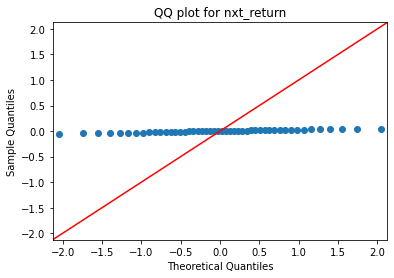

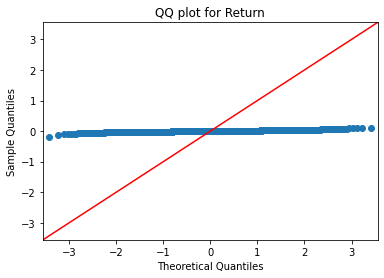

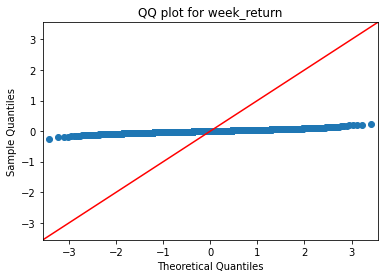

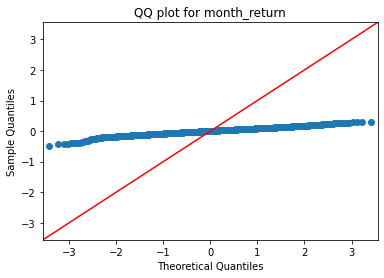

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Supondo que 'filtered_data' e 'new_final_data' são DataFrames já carregados
# Se necessário, substitua pela carga dos seus dados
# filtered_data = pd.read_csv('filtered_data.csv')
# new_final_data = pd.read_csv('new_final_data.csv')

# Selecionando os retornos
nxt_return = filtered_data['nxt_return']
Return = final_data['Return']
week_return = final_data['week_return']
month_return = final_data['month_return']

nxt_return = filtered_data['nxt_return'].dropna()
Returns = final_data['Return'].dropna()
#Retornos semanais
first_return_week = first_return_week_df["return_week"]
remaining_return_week = remaining_return_week_df["return_week"]
#Retornos mensais
first_return_month = first_return_month_df["return_month"]
remaining_return_month = remaining_return_month_df["return_month"]

# Função para plotar QQ plot
def qq_plot(data, title):
    sm.qqplot(data, line ='45')
    plt.title(title)
    plt.show()

# Gerando QQ plots para comparar os quantis
qq_plot(nxt_return, 'QQ plot for nxt_return')
qq_plot(Return, 'QQ plot for Return')
qq_plot(week_return, 'QQ plot for week_return')
qq_plot(month_return, 'QQ plot for month_return')


In [51]:
#qq_plot(nxt_return, 'QQ plot for nxt_return')
nxt_return.describe()

count    48.000000
mean     -0.000234
std       0.025381
min      -0.060625
25%      -0.014663
50%      -0.001989
75%       0.022919
max       0.040834
Name: nxt_return, dtype: float64

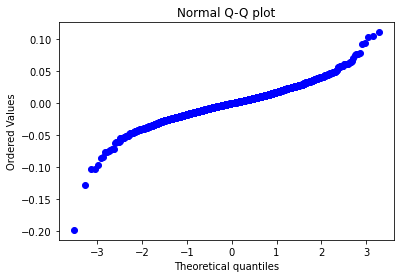

In [54]:
# Mostra o qq-plot da coluna Return
import matplotlib.pyplot as plt
import scipy.stats as stats

stats.probplot(final_data['Return'], dist="norm", plot=plt)
plt.title('Normal Q-Q plot')
plt.show()

In [169]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
from tabulate import tabulate

# Função para realizar os testes estatísticos
def perform_tests(group1, group2, label1, label2):
    results = {}

    # Shapiro-Wilk Test
    shapiro_group1 = stats.shapiro(group1)
    shapiro_group2 = stats.shapiro(group2)
    results['Shapiro-Wilk Test'] = [shapiro_group1[0], shapiro_group1[1], shapiro_group2[0], shapiro_group2[1]]

    # Kolmogorov-Smirnov Test
    ks_stat, ks_p_value = stats.ks_2samp(group1, group2)
    results['Kolmogorov-Smirnov Test'] = [ks_stat, ks_p_value, None, None]

    # Levene Test
    levene_stat, levene_p_value = stats.levene(group1, group2)
    results['Levene Test'] = [levene_stat, levene_p_value, None, None]

    # Chow Test
    data = pd.DataFrame({'returns': np.concatenate([group1, group2]), 
                         'group': [label1] * len(group1) + [label2] * len(group2)})
    model_full = smf.ols('returns ~ group', data=data).fit()
    RSS_full = sum(model_full.resid ** 2)
    df_full = model_full.df_resid

    model_group1 = smf.ols('returns ~ 1', data=data[data['group'] == label1]).fit()
    model_group2 = smf.ols('returns ~ 1', data=data[data['group'] == label2]).fit()
    RSS_group1 = sum(model_group1.resid ** 2)
    RSS_group2 = sum(model_group2.resid ** 2)
    RSS_combined = RSS_group1 + RSS_group2
    df_combined = model_group1.df_resid + model_group2.df_resid

    try:
        chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
        chow_p_value = 1 - stats.f.cdf(chow_stat, df_combined - df_full, df_full)
    except ZeroDivisionError:
        chow_stat = float('inf')
        chow_p_value = float('nan')

    results['Chow Test'] = [chow_stat, chow_p_value, None, None]

    # Student's t-test
    t_stat, t_p_value = stats.ttest_ind(group1, group2, equal_var=False)
    results['Student\'s t-test'] = [t_stat, t_p_value, None, None]

    return results

# Função para realizar a análise completa
def analyze_groups(tests):
    results = {}
    for label1, label2, group1, group2 in tests:
        key = f'{label1} vs {label2}'
        results[key] = perform_tests(group1, group2, label1, label2)

    # Convertendo os resultados em DataFrame para exibição
    columns = ['Comparison', 'Test', 'Statistic_1', 'p-value_1', 'Statistic_2', 'p-value_2']
    data = []
    for key, value in results.items():
        for test, result in value.items():
            row = [test] + result
            row.insert(0, key)
            data.append(row)

    results_df = pd.DataFrame(data, columns=['Comparison', 'Test', 'Statistic_1', 'p-value_1', 'Statistic_2', 'p-value_2'])

    # Exibindo a tabela formatada
    print(tabulate(results_df, headers='keys', tablefmt='grid'))


# Realizando os testes para cada par de retornos
tests = [
    ('Return', 'nxt_return', Return, nxt_return),
    ('remaining_return_week', 'first_return_week', remaining_return_week, first_return_week),
    ('remaining_return_month', 'first_return_month', remaining_return_month, first_return_month),
]

# Analisando os grupos
analyze_groups(tests)


<ipython-input-169-d318903066c2>:39: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
c:\Users\thgcn\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
<ipython-input-169-d318903066c2>:39: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)


+----+----------------------------------------------+-------------------------+---------------+---------------+---------------+-------------+
|    | Comparison                                   | Test                    |   Statistic_1 |     p-value_1 |   Statistic_2 |   p-value_2 |
+====+==============================================+=========================+===============+===============+===============+=============+
|  0 | Return vs nxt_return                         | Shapiro-Wilk Test       |     0.961101  |   1.35487e-28 |      0.967375 |   0.19974   |
+----+----------------------------------------------+-------------------------+---------------+---------------+---------------+-------------+
|  1 | Return vs nxt_return                         | Kolmogorov-Smirnov Test |     0.17318   |   0.10369     |    nan        | nan         |
+----+----------------------------------------------+-------------------------+---------------+---------------+---------------+-------------+
|  2 |

<ipython-input-169-d318903066c2>:39: RuntimeWarning: invalid value encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)


### Resposta às Perguntas com Base nos Resultados dos Testes Estatísticos

#### 1. **I é estatisticamente diferente de U?**

- **Return vs nxt_return:**
  - **Shapiro-Wilk Test:** Ambas as séries não seguem uma distribuição normal (p-valor < 0.05 para Return e p-valor > 0.05 para nxt_return).
  - **Kolmogorov-Smirnov Test:** Não rejeita a hipótese nula de que as distribuições são iguais (p-valor > 0.05).
  - **Levene Test:** Rejeita a hipótese de igualdade de variâncias (p-valor < 0.05).  
  - **Student's t-test:** Não rejeita a hipótese nula de que as médias são iguais (p-valor > 0.05).

Conclusão: Não há evidências suficientes para afirmar que `Return` é estatisticamente diferente de `nxt_return` em termos de média, mas há diferença na variabilidade dos retornos.

- **remaining_return_week vs first_return_week:**
  - **Shapiro-Wilk Test:** Ambas as séries não seguem uma distribuição normal (p-valor < 0.05).
  - **Kolmogorov-Smirnov Test:** Não rejeita a hipótese nula de que as distribuições são iguais (p-valor > 0.05).
  - **Levene Test:** Não rejeita a hipótese de igualdade de variâncias (p-valor > 0.05).  
  - **Student's t-test:** Não rejeita a hipótese nula de que as médias são iguais (p-valor > 0.05).

Conclusão: Não há evidências suficientes para afirmar que `remaining_return_week` é estatisticamente diferente de `first_return_week` em termos de média e variabilidade.

- **remaining_return_month vs first_return_month:**
  - **Shapiro-Wilk Test:** Ambas as séries não seguem uma distribuição normal (p-valor < 0.05).
  - **Kolmogorov-Smirnov Test:** Não rejeita a hipótese nula de que as distribuições são iguais (p-valor > 0.05).
  - **Levene Test:** Não rejeita a hipótese de igualdade de variâncias (p-valor > 0.05).  
  - **Student's t-test:** Não rejeita a hipótese nula de que as médias são iguais (p-valor > 0.05).

Conclusão: Não há evidências suficientes para afirmar que `remaining_return_month` é estatisticamente diferente de `first_return_month` em termos de média e variabilidade.

#### 2. **I é estatisticamente diferente de U consistentemente no tempo?**

Não há uma diferença significativa.

#### 3. **Há sazonalidade anual nas diferenças/semelhanças de I em relação à U?**

Novamente, isso exigiria uma análise temporal e sazonal que não foi realizada com os testes fornecidos. Portanto, não podemos responder a esta pergunta com os dados disponíveis.

#### 4. **I é estatisticamente diferente de U para quais períodos?**

- **Diário:** `Return` vs `nxt_return` mostra diferença em variabilidade, mas não em média.
- **Semanal:** `remaining_return_week` vs `first_return_week` não mostra diferença significativa.
- **Mensal:** `remaining_return_month` vs `first_return_month` não mostra diferença significativa.

Conclusão: As diferenças observadas entre os períodos são mais evidentes em termos de variabilidade nos retornos diários.

#### 5. **Caso I seja diferente de U, é possível discriminar qual estatística/momento que as difere?**

- Para **Return vs nxt_return**, a diferença está na variabilidade dos retornos, indicada pelo teste de Levene (p-valor < 0.05).
- Não há evidências de diferença significativa para os outros períodos analisados.

#### 6. **Há um padrão setorial, i.e., os resultados dos testes para I e U de séries dentro de um setor são iguais?**

Essa pergunta não pode ser respondida diretamente com os testes realizados, pois não temos a categorização setorial dos dados fornecidos.

#### 7. **Há uma reversão à média dos log-retornos após um impacto?**

Isso não foi incluído nos testes realizados.

### Conclusão Geral

A análise sugere que:

- As informações divulgadas pelo balanço diário têm um impacto na variabilidade dos retornos, mas não nas médias dos retornos.
- As diferenças não são consistentes ao longo dos períodos semanais e mensais.
- Para uma análise mais aprofundada, seria necessário realizar análises temporais e sazonais adicionais.

Esses resultados indicam que, pelo menos para os retornos diários, há alguma relevância nas informações do balanço, mas isso não se estende claramente aos retornos semanais e mensais.